# Diagnostic Measures
Now that we have established both the core assumptions of the linear model and have discussed some important data features, we can now examine some of the key diagnostic measures we will use for assessing both of these elements. Importantly, these diagnostics are all calculated directly from the model itself. As such, we do not usually check the assumptions *before* fitting the model. Instead, we fit the model, derive diagnostic measures from the model and then check its suitability. This is important because we want our diagnostics to be tied as closely to the model as possible. Although possible to create useful visualisations from the raw data, we can only accurately assess the model if we have the precise numeric values the model is using. This necessitates fitting the model *first*. However, we need to take care that we do not enter into *interpreting* the model until we are satisfied the assumptions are suitably met.

## Leverage Values
We will start our tour of diagnostic measures with the *leverage values* because, as we will see below, these have some important consequences for interpreting other diagnostic measures. As mentioned above, leverage concerns the degree to which a single data point is influencing the model fit. The *leverage values* are measures of leverage and range $0 \leq h_{i} \leq 1$. These can be interpreted as

- If $h_{i}$ is close to 0, then the predicted value $\hat{y}_{i}$ is mostly determined by the other data points.
- If $h_{i}$ is close to 1, then the predicted value $\hat{y}_{i}$ is determined almost entirely by $y_{i}$. 

So, in this sense, higher leverage means that the predicted value of point $i$ is not very related to the rest of the data in the dataset, as it depends almost entirely on that single point. This implies that this point is an outlier in predictor space, but also that the model fit for that combination of predictor values is not a balance between mutliple observations, as it is biased towards that single observation.

The actual calculation of the leverage values in multiple regression is complex and involves diving into the linear algebraic representation of linear models (which is beyond the scope of the unit). However, they can be easily extracted in `R` using the `hatvalues()` function[^hatmat-foot]

In [7]:
data(mtcars)
mod <- lm(mpg ~ wt + hp + cyl, data=mtcars)
lev <- hatvalues(mod)
print(lev)

          Mazda RX4       Mazda RX4 Wag          Datsun 710      Hornet 4 Drive 
         0.07495754          0.05815750          0.08563345          0.05334688 
  Hornet Sportabout             Valiant          Duster 360           Merc 240D 
         0.10981841          0.06986080          0.11762078          0.15741830 
           Merc 230            Merc 280           Merc 280C          Merc 450SE 
         0.15201954          0.04691578          0.04691578          0.07862927 
         Merc 450SL         Merc 450SLC  Cadillac Fleetwood Lincoln Continental 
         0.08370579          0.08169851          0.20155034          0.24373270 
  Chrysler Imperial            Fiat 128         Honda Civic      Toyota Corolla 
         0.23547715          0.08274176          0.13078212          0.09961207 
      Toyota Corona    Dodge Challenger         AMC Javelin          Camaro Z28 
         0.09155927          0.14918089          0.15654328          0.10338967 
   Pontiac Firebird         

None of the data here exerts very large leverage in *absolute* terms, as all the leverage values are quite far below 1. Neverthless, it is typical to interpret leverage in a *relative* fashion for a given dataset. As such, a common cutoff for defining *high leverage* is $h_{i} > 2\frac{p}{n}$, where $p$ is the number of model parameters and $n$ is the sample size. For reasons related to how leverage is calculated, this gives a cutoff of *twice* the average leverage[^levcutoff-foot]. For the `mtcars` model above this would be

In [8]:
n       <- length(mod$fitted.values)
p       <- length(mod$coefficients)
big.lev <- 2*p/n
print(big.lev)

[1] 0.25


So our *relative* cutoff would be $h_{i} > 0.25$. We can examine any concerning cases using

In [9]:
print(lev[lev > big.lev])

Maserati Bora 
    0.4635658 


So we have one observation with high relative leverage, suggesting this may be an outlier in predictor space and may be unduly influencing the model fit. We would need to examine this specific case in more detail and assess why its particular combination of predictor values is unusual, and whether any mistakes have been made. We could also assess the sensitivity of our model to this point by fitting it both *with* and *without* this observation, taking note of whether our inference substantially changes. We will see how leverage factors into some standard diagnostic plots a little later.

## Residuals
Beyond leverage values, one of the most useful diagnostic we can get from our model is the *residuals*. As we know, many of the linear model assumptions centre on the distribution of the errors. As such, it would stand to reason that we can use the residuals as a proxy for the errors to assess these assumptions (though there is a catch, as we will discuss below). Beyond the distributional assumptions, we can also use the residuals to detect outliers, check for evidence of non-linearity in the model fit, and can diagnose any issues with the assumption of a continuous outcome when working with data that is technically non-continuous. So, as we can see, the residuals are incredibly useful as a diagnostic tool and can be extracted using the `resid()` function in `R`.

In [10]:
resid.raw <- resid(mod)
print(resid.raw)

          Mazda RX4       Mazda RX4 Wag          Datsun 710      Hornet 4 Drive 
         -1.8204257          -1.0128476          -3.1603990           0.4639233 
  Hornet Sportabout             Valiant          Duster 360           Merc 240D 
          1.5322025          -2.1503588          -1.1934238           0.6356864 
           Merc 230            Merc 280           Merc 280C          Merc 450SE 
         -0.4957351          -0.7890124          -2.1890124           1.3175861 
         Merc 450SL         Merc 450SLC  Cadillac Fleetwood Lincoln Continental 
          1.1408152          -0.8008361          -0.4944331           0.2370012 
  Chrysler Imperial            Fiat 128         Honda Civic      Toyota Corolla 
          4.5573819           5.5725355           1.4673228           5.8985522 
      Toyota Corona    Dodge Challenger         AMC Javelin          Camaro Z28 
         -3.9290355          -1.8653922          -2.4345849          -1.3383411 
   Pontiac Firebird         

For each car, the residual value represents the difference between the model prediction and the original data. The residuals are therefore in the original units of the outcome which, in this example, is MPG. This can be difficult to interpret in terms of defining which residuals are *large*, but this is something we will come back to below.

### Some Complexities with Raw Residuals
As indicated above, it would seem reasonable to assume that we can use the residuals as a proxy for the true errors and thus use them to assess the distributional assumptions of our model. Although we can do this in an *approximate* fashion, there is an important technical detail to consider. One of the main reasons that we have made a point of distinguishing *errors* from *residuals* is that the estimation process *changes the distributional properties of the errors*. This means that *errors* and *residuals* are not expected to behave identically. So while it is correct to assume

$$
\epsilon_{i} \overset{\text{i.i.d.}}{\sim} \mathcal{N}\left(0,\sigma^{2}\right),
$$

it is *not* technically correct to assume the same for the *residuals*. In fact, the variance of the residuals is *not* $\sigma^{2}$, as we might expect, it is

$$
\text{Var}\left(e_{i}\right) = \sigma^{2}\left(1 - h_{i}\right).
$$

So, rather than being constant (as is the case with the true *errors*), the variance of the residuals is *scaled* by the leverage. Because we have a leverage value for each observation, the variance will be different for each observation. In other words, the residuals *cannot be homoscedastic*, even if the errors are. In the equation above, the key element is that the variance is scaled by $\left(1 - h_{i}\right)$. So, if $h_{i} = 0.8$ then the variance would be multiplied by $1 - 0.8 = 0.2$. As such, the *higher* the leverage, the *smaller* the variance gets.

Why does this happen? It is actually due to the inherent properties of estimating the parameters from data. Because observations with high leverage pull the model fit towards them, the variance around those points will be smaller than elsewhere in the fit. As such, points with high leverage will often sit closer to the regression line, making the variance *smaller* for that particular combination of predictor values. This is illustrated in the plot of residuals below. Although these data are simulated from a homoscedastic population, we can see that the variance (illustrated by the green dashed lines) shrinks as the leverage of individual points gets higher. The points in red indicate those that are above the typical cutoff of twice the average leverage. We can also see that the degree to which we may be mislead by the heteroscedasticity of the residuals will depend upon how extreme the leverage is.

In [26]:
options(repr.plot.width=12, repr.plot.height=7)

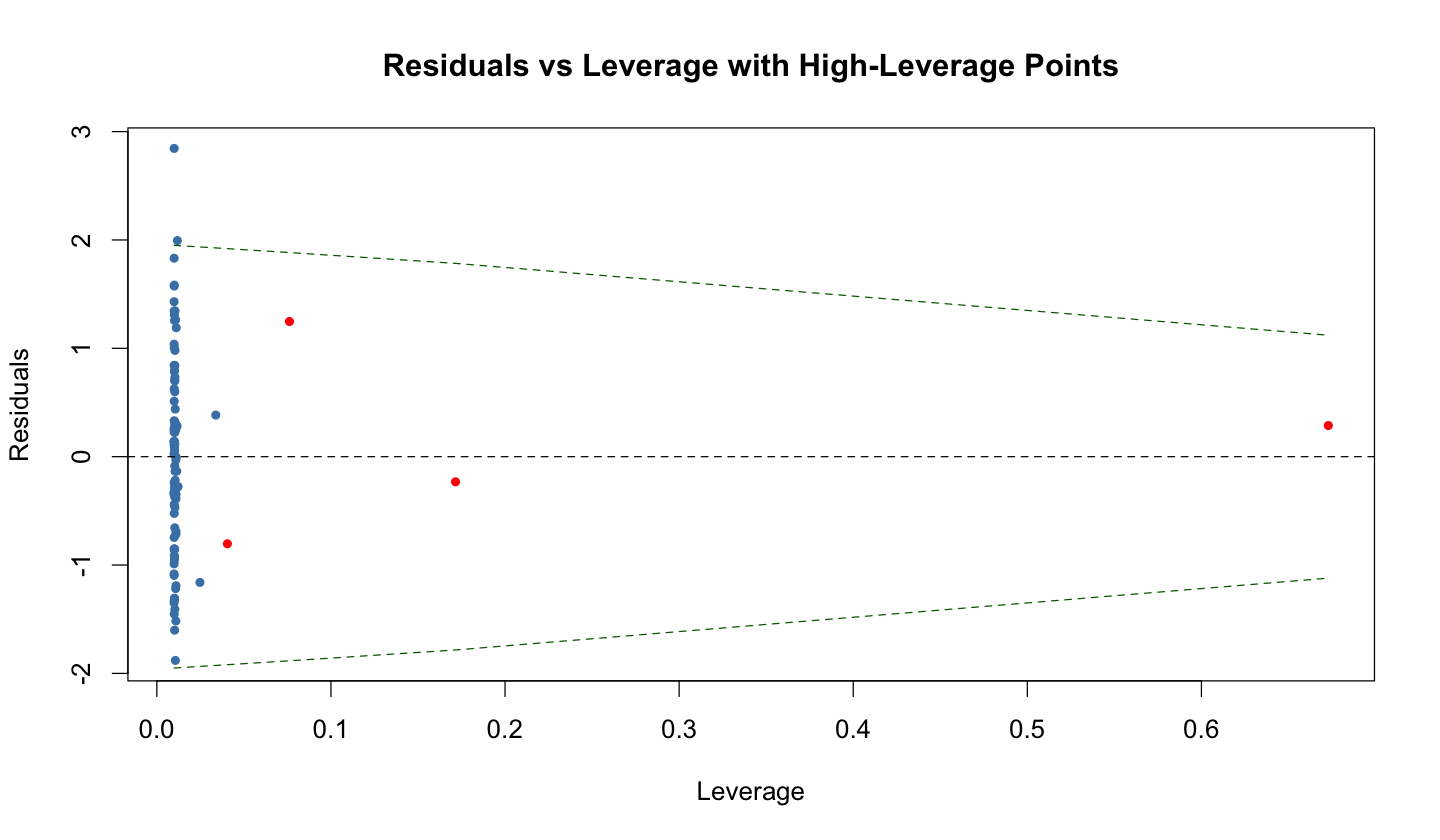

In [34]:
set.seed(42)

# Main body: clustered near 0
n_main <- 95
x_main <- rnorm(n_main, mean = 0, sd = 1)

# Extremes: far from the center
x_extreme <- c(-50,-25, -10, -8, 10, 15)  # Five extreme values
x <- c(x_main, x_extreme)

# True relationship
y_true <- 2 + 0.5 * x

# Homoscedastic errors
sigma <- 1
errors <- rnorm(length(x), mean = 0, sd = sigma)
y <- y_true + errors

# Fit linear model
mod <- lm(y ~ x)

# Extract residuals and leverage
residuals <- resid(mod)
leverage  <- hatvalues(mod)

par(cex=1.3)

# Plot residuals vs leverage
plot(leverage, residuals,
     xlab = "Leverage", ylab = "Residuals",
     main = "Residuals vs Leverage with High-Leverage Points",
     pch = 20,
     col = ifelse(leverage > 2*mean(leverage), "red", "steelblue"))
abline(h = 0, lty = 2)

# Add theoretical envelope: ±1.96 * sqrt(σ² * (1 - h))
lev_sorted <- sort(leverage)
lines(lev_sorted, +qnorm(0.975) * sigma * sqrt(1 - lev_sorted),
      col = "darkgreen", lty = 2)
lines(lev_sorted, -qnorm(0.975) * sigma * sqrt(1 - lev_sorted),
      col = "darkgreen", lty = 2)


## Standardised Residuals
At this point, we have established that residuals are potentially very useful diagnostically, but they have two issues:

1. Residuals are in the original units of the outcome and therefore difficult to interpret in terms of which are *large* and which are *small*.
2. The homoscedasticity of the residuals depends upon the leverage, even if the true errors are homoscedastic. So any assessment of constant variance that uses the residuals could be misleading.

In order to solve both these issues, we can *standardise* the residuals by computing 

$$
r_{i} = \frac{e_{i}}{\hat{\sigma}\sqrt{1 - h_{i}}},
$$

which is just the residual divided by its theoretical standard deviation. This has the effect of scaling the residuals into units of standard deviation. So, for the purpose of outlier detection, we just need to decide how many standard deviations we would consider *large*. Typical values are either 2 or 3 standard deviations. This scaling also has an additional advantage, because the effect of leverage is removed from each residual. This makes standardised residuals useful for decting outliers *and* for assessing homoscedasticity without the misleading effect of leverage. This is shown below where we can see that there is no longer any dependence between the variance and leverage when the residuals are standardised.

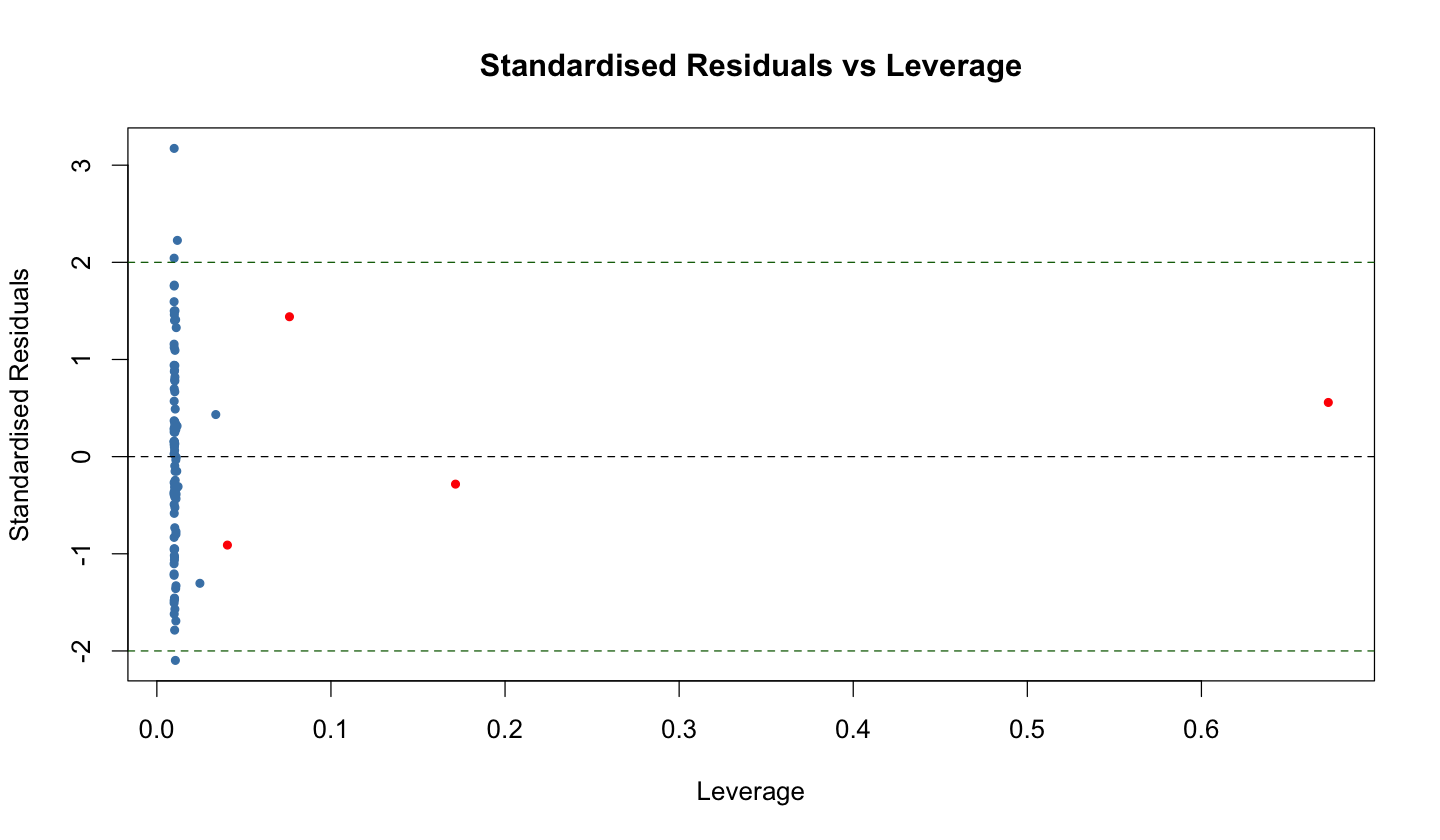

In [40]:
set.seed(42)

# Simulate predictor: mostly near 0, with high-leverage extremes
n_main <- 95
x_main <- rnorm(n_main, mean = 0, sd = 1)
x_extreme <- c(-50,-25, -10, -8, 10, 15)  # Five extreme values
x <- c(x_main, x_extreme)

# True model
y_true <- 2 + 0.5 * x

# Homoscedastic errors
sigma <- 1
errors <- rnorm(length(x), mean = 0, sd = sigma)
y <- y_true + errors

# Fit linear model
mod <- lm(y ~ x)

# Extract components
e <- resid(mod)
h <- hatvalues(mod)
s_hat <- summary(mod)$sigma  # Estimated residual standard deviation

# Standardised residuals
r_standard <- e / (s_hat * sqrt(1 - h))

par(cex=1.3)

# Plot: standardised residuals vs leverage
plot(h, r_standard,
     xlab = "Leverage", ylab = "Standardised Residuals",
     main = "Standardised Residuals vs Leverage",
     pch = 20,
     col = ifelse(h > 2*mean(leverage), "red", "steelblue"))
abline(h = 0, lty = 2)
abline(h = c(-2, 2), col = "darkgreen", lty = 2)


Standardised residuals can be calculated in `R` using the `rstandard()` function

In [ ]:
data(mtcars)
mod       <- lm(mpg ~ wt + hp + cyl, data=mtcars)
resid.std <- rstandard(mod)
print(resid.std)

          Mazda RX4       Mazda RX4 Wag          Datsun 710      Hornet 4 Drive 
         -0.7536168          -0.4155405          -1.3159524           0.1898494 
  Hornet Sportabout             Valiant          Duster 360           Merc 240D 
          0.6465994          -0.8877596          -0.5058544           0.2757372 
           Merc 230            Merc 280           Merc 280C          Merc 450SE 
         -0.2143459          -0.3217930          -0.8927730           0.5465378 
         Merc 450SL         Merc 450SLC  Cadillac Fleetwood Lincoln Continental 
          0.4745219          -0.3327434          -0.2203141           0.1085104 
  Chrysler Imperial            Fiat 128         Honda Civic      Toyota Corolla 
          2.0752892           2.3166769           0.6266424           2.4750788 
      Toyota Corona    Dodge Challenger         AMC Javelin          Camaro Z28 
         -1.6413307          -0.8052115          -1.0554848          -0.5627602 
   Pontiac Firebird         

Here we can see a few observations with residuals larger than 2 standard deviations from the model fit.

In [14]:
print(resid.std[abs(resid.std) > 2])

        9        23        33        79 
 2.382486  3.228289 -2.064226  2.044849 


These could be potential outliers, though we will see ways of visualising these later so that they can be seen in context with the rest of the data. We will also see how visualisations can be used to assess homoscedasticity.

## Studentised Residuals
An alternative, but potentially more powerful approach, to standardised residuals is to computer *studentised* residuals. These are based on scaling the residuals into standard deviation units, but they do so differently for each individual datapoint. Rather than using the global variance estimate $\hat{\sigma}^{2}$, studentised residuals use $\hat{\sigma}^{2}_{-i}$, which is the variance estimate from a model with datapoint $i$ removed. 

$$
t_{i} = \frac{e_{i}}{\hat{\sigma}_{-i}\sqrt{1 - h_{i}}},
$$

The reason for doing this is that an outlier will artifically inflate the global variance estimate, meaning that extreme points will have *smaller* values when standardised. In other words, outliers can hide and appear less extreme than they really are. This is corrected by removing the point in question from the variance when scaling it into standard deviation units. 

Studentised residuals can be calculated using the `rstudent()` function in `R`.

In [24]:
resid.t <- rstudent(mod)
print(resid.t)

          Mazda RX4       Mazda RX4 Wag          Datsun 710      Hornet 4 Drive 
         -0.7476584          -0.4093168          -1.3341552           0.1865485 
  Hornet Sportabout             Valiant          Duster 360           Merc 240D 
          0.6397422          -0.8842967          -0.4990246           0.2711369 
           Merc 230            Merc 280           Merc 280C          Merc 450SE 
         -0.2106564          -0.3165804          -0.8894363           0.5395753 
         Merc 450SL         Merc 450SLC  Cadillac Fleetwood Lincoln Continental 
          0.4678563          -0.3273955          -0.2165319           0.1065775 
  Chrysler Imperial            Fiat 128         Honda Civic      Toyota Corolla 
          2.2153833           2.5303244           0.6197115           2.7498370 
      Toyota Corona    Dodge Challenger         AMC Javelin          Camaro Z28 
         -1.6953756          -0.8000188          -1.0577210          -0.5557716 
   Pontiac Firebird         

Here we can see that the previous standardised residuals with values over 2 have all gotten *bigger* when using studentised residuals. This shows how their inclusion was artifically inflating the variance and thus making their standardised score *smaller*. This makes studentised residuals much more useful for detecting outliers.

In [25]:
print(resid.t[abs(resid.t) > 2])

Chrysler Imperial          Fiat 128    Toyota Corolla 
         2.215383          2.530324          2.749837 


It is also interesting to note that the `Maserati Bora`, which had high relative leverage, has *not* been identified as an outlier. This highlights how the two concepts are somewhat independent, particularly when we recognise that observations with high leverage will often live close to the regression line.

```{admonition} The Distribution of Studentised Residuals
:class: tip
Another advantage of *studentised* residuals is that they have a known distribution. As the notation $t_{i}$ implies, the residuals are distributed as a $t$-distribution with $n-p-1$ degrees of freedom. This means that we *could* calculate a $p$-value for each residual to test the null hypothesis that this observation is consistent with the model. For instance, we can calculate `2 * pt(abs(resid.t), df=mod$df.residual-1, lower.tail=FALSE)` to get $p$-values for the studentised residuals. *However*, we have calculated $n$ tests here and so would need some form of correction (which we will discuss further next week). Furthermore, we are again relying on NHST here for assumption checking, which we have already indicated is flawed. However, we will see how this distribution crops up again a little later on. 
```

## Predicted/Fitted Values
... These can be extracted using the `fitted()` function in `R`, as shown below.

In [18]:
mod.fit <- fitted(mod)

## The Variance Inflation Factor (VIF)
Although raw correlation between the predictors can be one sign, the advantage of the VIF is that it characterised the precise issue that we are concerned about, in terms of the *inflation* of the standard errors when a variable is included in the model.

... This can be calculated using the `vif()` function from the `car` package, as shown below.

In [19]:
library(car)
print(vif(mod.multicol))

Loading required package: carData



      wt  wt.copy 
19.12063 19.12063 


In general, we can take:

- VIF = 1 &mdash; No multicollinearity
    - No issues and no action required.
- 1 < VIF < 5 &mdash; Small to moderate multicollinearity. 
    - Some caution needed, but not usually a problem for the model.
- VIF > 5 &mdash; High multicollinearity. 
    - Standard errors will be larger than usual. 
    - Inference will become unstable. 
    - Some mitigation will usually be needed.
- VIF > 10 &mdash; Severe multicollinearity. 
    - Standard errors will have blown-up at this point. 
    - Inference will become untrustworthy.
    - This cannot be ignored and something needs to be done.

In the example above, both `wt` and `wt.copy` have VIF > 10, showing *severe* multicollinearity. This points to a big problem with the model, specifically in relation to those two predictors. Notice that `hp` has 1 < VIF < 5, which gives little reason for concern. Th easiest solution here would be to remove either `wt` or `wt.copy`, though we will see an alternative method known as *ridge regression* at the end of the lesson.

[^NASA-foot]: [Faraway (2005)](https://www.utstat.toronto.edu/~brunner/books/LinearModelsWithR.pdf) provides a real-world example of why this is *not* good practise. This concerns the delay in the discovery of the hole in the Ozone layer due to NASA's automatic data analysis algorithms discarding very low readings assumed to be mistakes.

[^hatmat-foot]: This function is named after the fact that the leverage values come from the diagonal a special matrix called the *hat matrix*, which is used to form the predicted values (i.e. it puts the "hats" on $y$ to form $\hat{y}$).

[^levcutoff-foot]: You can verify this for yourself by also calculating `2 * mean(lev)`.